In [162]:
import numpy as np
import pandas as pd
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from pyphot import unit
import pyphot
from pdastro import pdastroclass
from scipy.signal import savgol_filter
from scipy.stats import tstd
import sys

from copy import deepcopy
from scipy.interpolate import interp1d
from astropy.modeling.functional_models import Gaussian1D

plt.style.use('default')

In [163]:
def flux2mag(flux, m0=0):
    return m0-2.5*np.log10(flux)

def mag2flux(mag, m0 = 0):
    return 10**((m0-mag)/2.5)

def dflux2dmag(flux, dflux):
    return 2.5/np.log(10)*dflux/flux

def dmag2dflux(mag, dmag, m0=0):
    return mag2flux(mag, m0 = 0)*np.log(10)/2.5*dmag

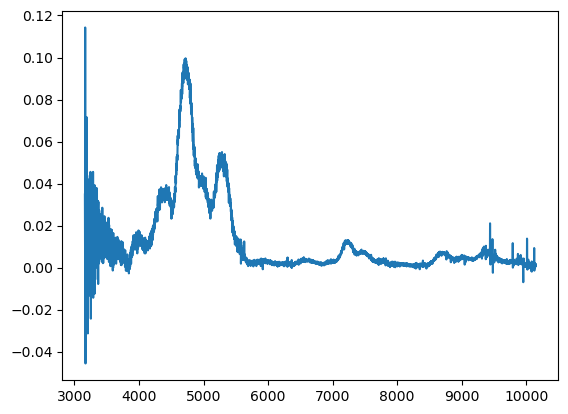

In [213]:
# read in the spectra as an instance of pdastroclass for ease of computations later on. plot it
spec = pdastroclass()
spec.t = pd.read_csv('2023bee-combined-20240214_ap1.flm', skiprows=np.arange(0,8), names = ['wavelength', 'flux', 'dflux'], delimiter= ' ')
plt.plot(spec.t.wavelength, spec.t.flux)

(24.0, 12.0)

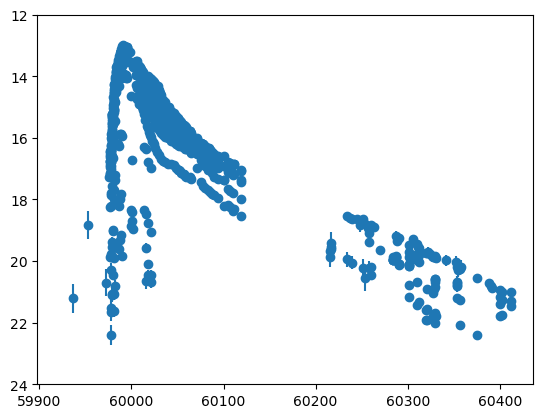

In [165]:
# read in the light curve, convert the dates to numeric data for correct ordering, do a primitive quality cut, and plot
lc = pdastroclass()
lc.t = pd.read_csv('2023bee_data.snana.txt', header=44, delim_whitespace=True)

end_ix=lc.ix_equal('MJD', 'END:')
lc.t=lc.t.drop(end_ix)
lc.t.MJD = pd.to_numeric(lc.t.MJD)

lc.t = lc.t[lc.t.MAGERR <= .5]

plt.scatter(lc.t.MJD, lc.t.MAG)
plt.errorbar(lc.t.MJD, lc.t.MAG, lc.t.MAGERR, ls='none')
plt.ylim(24,12)

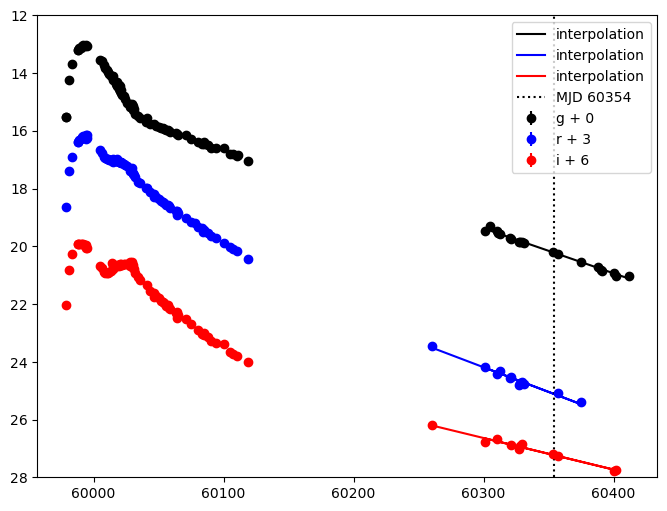

In [226]:
# separate out the light curve data from Pan-STARRS1's gri filters, and plot these three filters offset from one another.
# interpolate the magnitude in each filter at the day the spectrum was taken, using all data taken after MJD=60120, selected simply
# because that was a date on the early end of the gap in data evident through the plot. 

filters = lc.t.FLT.unique()
wanted_filts= [15,16,17]
usefilts = [filters[i] for i in wanted_filts]

plt.figure(figsize=(8,6))

colors=['black','b','r']
maglist = []

for i, filt in enumerate(usefilts): #plot ATLAS and ZTF bands
    # Filter out the data in certain filet and has reasonable uncertainty 
    ind = (lc.t.FLT==filt)&(lc.t.MAGERR>0.)&(lc.t.MAGERR<1.) 
    plt.errorbar(lc.t.MJD[ind], lc.t.MAG[ind]+3*i, lc.t.MAGERR[ind], linestyle = 'None', marker = 'o', 
                 label = filt + ' + ' + str(3*i), color = colors[i])
    
    # copy the quality cut indices for the current filter into a reindexed dataframe; separate out all indeces after 
    # the first "chunk" of observations ends and fit a line to those data; plot it and find the value at MJD=60345
    # to assume the SN magnitude on the day the spectrum was taken; add to a list 
    temp = lc.t[ind].copy().reset_index()
    ixs=(temp.MJD > 60120)
    a,b = np.polyfit(temp.MJD[ixs],temp.MAG[ixs],1)
    plt.plot(temp.MJD[ixs], a*temp.MJD[ixs]+(b+3*i), color=colors[i], label='interpolation')
    est_val = a*60354+b
    maglist.append(est_val)

plt.axvline(x=60354,color='black', ls='dotted', label = 'MJD 60354')
plt.ylim(28, 12)
plt.legend()

In [230]:
# find the difference between spectral magnitude and photometric magnitude in PS1 gri filters. 
# average the differences and convert to flux to determine a calibration constant for the spectrum

wavelength = np.array(spec.t.wavelength) * unit['AA']
flux = np.array(spec.t.flux) * unit['erg/s/cm**2/AA']

lib = pyphot.get_library()

diffs = []

f = lib['PS1_g']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_g_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_g_mags - maglist[0])

f = lib['PS1_r']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_r_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_r_mags - maglist[1])

f = lib['PS1_i']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_i_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_i_mags - maglist[2])

avg_mag_diff = np.mean(diffs)
calib = mag2flux(-avg_mag_diff)
# c_unc = (1/2.5)*(10**((1/2.5)*avg_mag_diff))*np.log(10)*np.std(diffs) 
# print(calib, "+/-", c_unc)

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

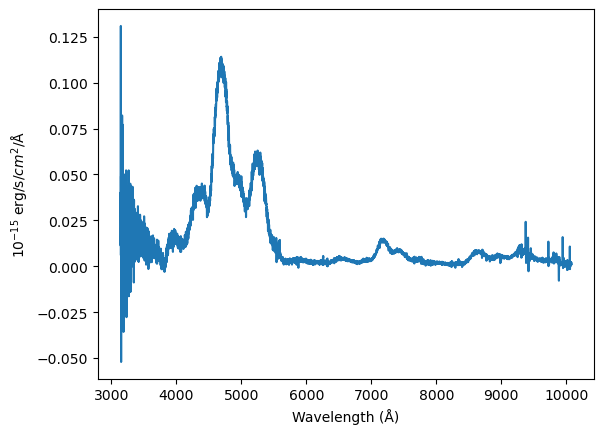

In [168]:
spec.t.flux = spec.t.flux*calib
spec.t.wavelength = spec.t.wavelength/1.0067

plt.plot(spec.t.wavelength, spec.t.flux*(10**15))
plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

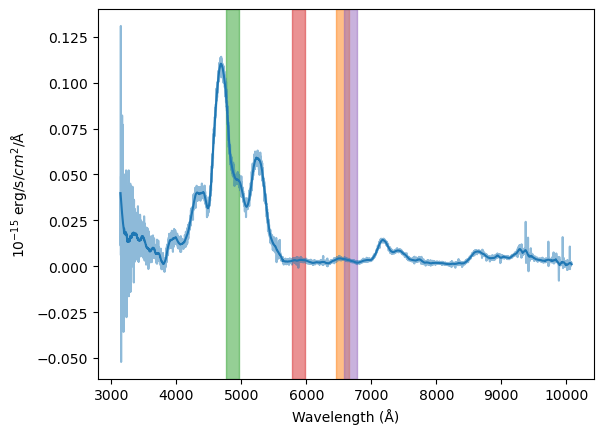

In [169]:
smoothed_bee = savgol_filter(spec.t.flux, 85, 3)

halpha = 6562.79
hbeta = 4861.35
hei5875 = 5875.61
hei6678 = 6678.15

plt.plot(spec.t.wavelength, spec.t.flux*(10**15), alpha=.5)
plt.plot(spec.t.wavelength, smoothed_bee*(10**15), color='tab:blue')

plt.axvspan(halpha-100, halpha+100, alpha=0.5, color='tab:orange')
plt.axvspan(hbeta-100, hbeta+100, alpha=0.5, color='tab:green')
plt.axvspan(hei5875-100, hei5875+100, alpha=0.5, color='tab:red')
plt.axvspan(hei6678-100, hei6678+100, alpha=0.5, color='tab:purple')

plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

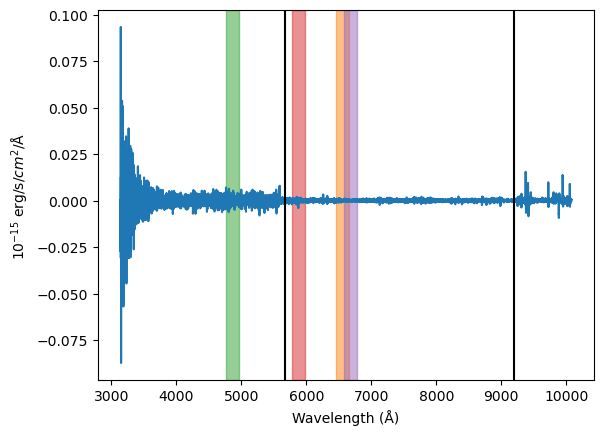

In [170]:
plt.plot(spec.t.wavelength, (spec.t.flux*(10**15))-(smoothed_bee*(10**15)), drawstyle='steps')

plt.axvspan(halpha-100, halpha+100, alpha=0.5, color='tab:orange')
plt.axvspan(hbeta-100, hbeta+100, alpha=0.5, color='tab:green')
plt.axvspan(hei5875-100, hei5875+100, alpha=0.5, color='tab:red')
plt.axvspan(hei6678-100, hei6678+100, alpha=0.5, color='tab:purple')

plt.axis()

begin = 5675
end = 9200
plt.axvline(begin, color='black')
plt.axvline(end, color='black')

plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

In [171]:
p = spec.ix_inrange('wavelength', begin, hei5875-100)
q = spec.ix_inrange('wavelength', hei5875+100, halpha-100)
r = spec.ix_inrange('wavelength', hei6678+100, end)
valid_ixs = list(np.concatenate([p, q, r]))

rms = spec.t.flux*(10**15)-(smoothed_bee*(10**15))

uncert_bee = tstd(spec.t.flux[valid_ixs]*(10**15)-(smoothed_bee[valid_ixs]*(10**15)))

In [172]:
# sofia's code
class Gaussian:
    def __init__(self, sigma, peak_appmag):
        self.peak_appmag = peak_appmag
        self.sigma = sigma
        self.g = self.new_gaussian(peak_appmag, sigma)

    def new_gaussian(self, peak_flux, sigma):
        x = np.arange(-100,100,.01)
        g1 = Gaussian1D(amplitude=peak_flux, stddev=sigma)(x)
        g2 = Gaussian1D(amplitude=peak_flux, stddev=sigma)(x)

        ind = np.argmin(abs(x))
        g3 = np.copy(g1)
        g3[ind:] = g2[ind:]
        gauss = np.array([x,g3])
        return gauss
            
    # get interpolated function of gaussian at peak MJD (peak_mjd) and match to time array (mjds)
    def gauss2fn(self, mjds, peak_mjd):
        g = deepcopy(self.g)
        g[0,:] += peak_mjd
                
        # interpolate gaussian
        fn = interp1d(g[0],g[1],bounds_error=False,fill_value=0)
        fn = fn(mjds)
        return fn 
            
    def __str__(self):
        return f'Gaussian with peak app mag {self.peak_appmag:0.2f} and sigma_sim {self.sigma}'

In [173]:
# width = 3sigma--include creating gaussian here?
def add_gaussian(pdastrodf, c, uncert, smoothed, emission_line, width, ix_range, snname, linename: str, xlims: list, ylims_plot1: list, ylims_plot2: list, gcolor=None, split_legend=True, legend_position=None, legend2newline=False):    
    if gcolor is None:
        gcolor='r'
    ix = pdastrodf.ix_inrange('wavelength', emission_line-ix_range, emission_line+ix_range)

    gaussian = Gaussian(width, 3*uncert)
    simflux = gaussian.gauss2fn(pdastrodf.t.loc[ix,'wavelength'], emission_line)
    pdastrodf.t['sim']=pdastrodf.t['flux'].copy()
    pdastrodf.t.sim[ix] += (simflux*c)
    smoothed_sim = smoothed.copy()
    smoothed_sim[ix] += (simflux*c)

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[2,1]})
    ax[0].axvspan(emission_line-(width*3), emission_line+(width*3), alpha=0.15, color='black')
    ax[0].axvline(emission_line, linestyle='dotted', color='black')
    ax[0].axvline(emission_line-(width*3), linestyle='dotted', color='black')
    ax[0].axvline(emission_line+(width*3), linestyle='dotted', color='black')

    stepspec, = ax[0].plot(pdastrodf.t.wavelength, pdastrodf.t.flux*(10**15), drawstyle='steps', color='black', alpha=.5, label=snname)
    if legend2newline is True:
        stepsim, = ax[0].plot(pdastrodf.t.wavelength[ix], pdastrodf.t.sim[ix]*(10**15), drawstyle='steps', linestyle='dashed', color='black', alpha=.75, label=snname +' \n+ '+ linename + ' \nflux limit')
    else: 
        stepsim, = ax[0].plot(pdastrodf.t.wavelength[ix], pdastrodf.t.sim[ix]*(10**15), drawstyle='steps', linestyle='dashed', color='black', alpha=.75, label=snname+' \n+ '+ linename + ' flux limit')

    smoothspec, = ax[0].plot(pdastrodf.t.wavelength, smoothed*(10**15), color='b', label=snname +' \nsmoothed')
    if legend2newline is True:
        smoothsim, = ax[0].plot(pdastrodf.t.wavelength[ix], smoothed_sim[ix]*(10**15), color=gcolor, label= snname + ' \nflux limit')
    else:
        smoothsim, = ax[0].plot(pdastrodf.t.wavelength[ix], smoothed_sim[ix]*(10**15), color=gcolor, label= snname + ' flux limit')

    ax[0].axis([xlims[0],xlims[1],ylims_plot1[0],ylims_plot1[1]])

    ax[1].plot(pdastrodf.t.wavelength, (pdastrodf.t.flux*(10**15))-(smoothed*(10**15)), drawstyle='steps',color='black', alpha=.5)
    ax[1].plot(pdastrodf.t.wavelength[ix], (pdastrodf.t.sim[ix]-smoothed[ix])*(10**15), drawstyle='steps', linestyle='dashed', color='black', alpha=.75)

    ax[1].plot(pdastrodf.t.wavelength, np.zeros(len(pdastrodf.t.wavelength)), color='b')
    ax[1].plot(pdastrodf.t.wavelength[ix], (smoothed_sim[ix]-smoothed[ix])*(10**15), color=gcolor)

    ax[1].axvspan(emission_line-33, emission_line+33, alpha=0.15, color='black')
    ax[1].axvline(emission_line, linestyle='dotted', color='black')
    ax[1].axvline(emission_line-33, linestyle='dotted', color='black')
    ax[1].axvline(emission_line+33, linestyle='dotted', color='black')

    ax[1].set_ylim(ylims_plot2[0], ylims_plot2[1])

    ax[1].set_xlabel('Wavelength (Å)')
    ax[0].set_ylabel('$10^{-15}$ erg/s/$cm^2$/Å')
    ax[1].set_ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

    if split_legend:
        if legend_position is None:
            legend1 = ax[0].legend(handles=[stepspec, smoothspec], loc='upper right')
            ax[0].add_artist(legend1)
            ax[0].legend(handles=[stepsim, smoothsim], loc='upper left')
        else: 
            legend1 = ax[0].legend(handles=[stepspec, smoothspec], loc=legend_position[0])
            ax[0].add_artist(legend1)
            ax[0].legend(handles=[stepsim, smoothsim], loc=legend_position[1])
    else:
        if legend_position is None:
            ax[0].legend()
        else: 
            ax[0].legend(loc=legend_position)
    

0.002816212577250551


/var/folders/6w/hdrgkhvj5gs8m0p18llgfyhh0002wp/T/ipykernel_73226/3470951508.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdastrodf.t.sim[ix] += (simflux*c)


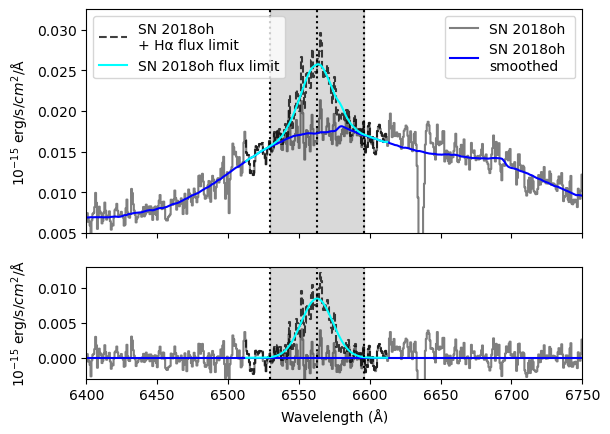

In [212]:
spec_oh = pd.DataFrame()
deimosspec = pdastroclass()
lrisspec = pdastroclass()

spec_oh = pd.read_csv('./other_sne/2018oh_2spec.txt', skiprows=np.arange(0,25), names = ['instrument','wavelength', 'flux', 'dflux'], delim_whitespace=True)
deimosspec.t = spec_oh.loc[spec_oh['instrument'].eq("DEIMOS")].copy()
lrisspec.t = spec_oh.loc[spec_oh['instrument'].eq("LRIS")].copy().reset_index()

smoothed_oh_deimos = savgol_filter(deimosspec.t.flux, 181, 2)
smoothed_oh_lris = savgol_filter(lrisspec.t.flux, 181, 2)

p = spec.ix_inrange('wavelength', smoothed_oh_deimos[0], hei5875-100)
q = spec.ix_inrange('wavelength', hei5875+100, halpha-100)
r = spec.ix_inrange('wavelength', hei6678+100, smoothed_oh_deimos[len(smoothed_oh_deimos)-1])
valid_ixs = list(np.concatenate([p, q, r]))

rms = deimosspec.t.flux*(10**15)-(smoothed_oh_deimos*(10**15))

uncert_oh = tstd(deimosspec.t.flux*(10**15)-(smoothed_oh_deimos*(10**15)))
print(uncert_oh)

add_gaussian(deimosspec, 10**(-15), uncert_oh, smoothed_oh_deimos, halpha, 11, 50, 'SN 2018oh', 'Hα', [6400,6750], [0.005,.0325], [-.003, .013], gcolor='cyan', split_legend=True)

0.0005940265672458845


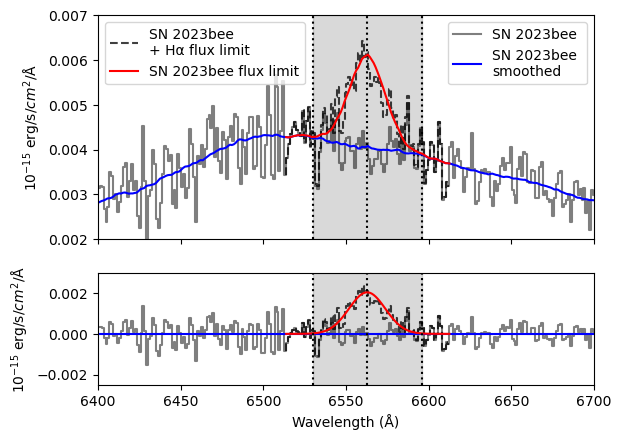

In [198]:
add_gaussian(spec, calib, uncert_bee, smoothed_bee, halpha, 11, 50, 'SN 2023bee', 'Hα', [6400,6700], [.002,.007], [-.0025, .003], split_legend=True)

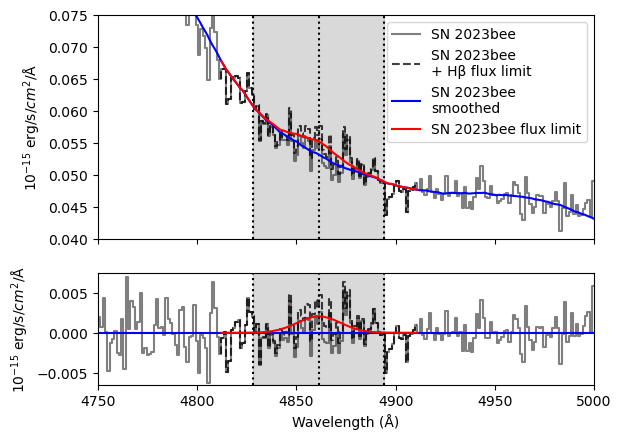

In [184]:
add_gaussian(spec, calib, uncert_bee, smoothed_bee, hbeta, 11, 50,'SN 2023bee', 'Hβ', [4750,5000], [.04,.075], [-.0065, .0075], split_legend=False)

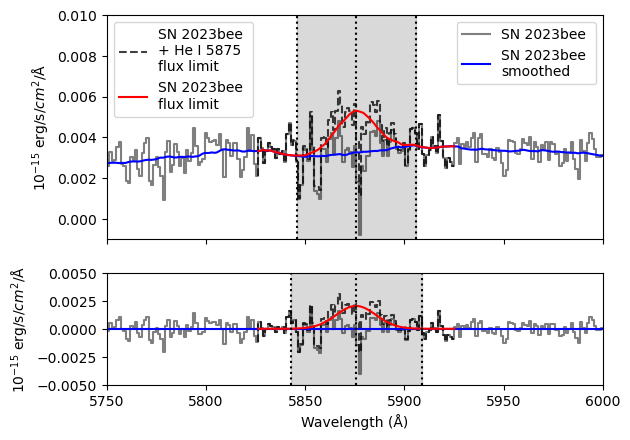

In [185]:
add_gaussian(spec, calib, uncert_bee, smoothed_bee, hei5875, 10, 50, 'SN 2023bee', 'He I 5875', [5750,6000], [-.001,.01], [-.005, .005], split_legend=True, legend2newline=True)

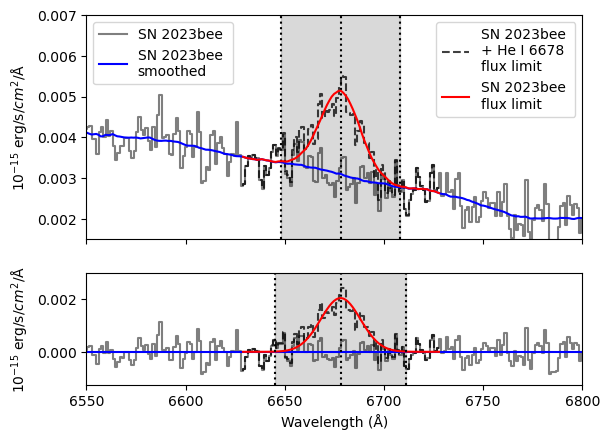

In [160]:
add_gaussian(spec, calib, uncert_bee, smoothed_bee, hei6678, 10, 50, 'SN 2023bee', 'He I 6678', [6550,6800], [.0015,.007], [-.00125, .003], split_legend=True, legend2newline=True, legend_position=['upper left', 'upper right'])

In [68]:
flux2 = np.array(spec.flux) * unit['erg/s/cm**2/AA']

lib2 = pyphot.get_library()

f2 = lib2['PS1_g']
fluxes = f2.get_flux(wavelength, flux2, axis=-1)

f2 = lib2['PS1_r']
fluxes = f2.get_flux(wavelength, flux2, axis=-1)

f2 = lib2['PS1_i']
fluxes = f2.get_flux(wavelength, flux2, axis=-1)

AttributeError: 'pdastroclass' object has no attribute 'flux'